# 2.8 推論の実施の付録。学習と検証のDataLoaderに実施する

本ファイルでは、学習させたSSDで物体検出を行います。


VOC2012の訓練データセットと検証データセットに対して、学習済みSSDの推論を実施し、推論結果と正しい答えであるアノテーションデータの両方を表示させるファイルです。

学習させたSSDモデルが正しいアノテーションデータとどれくらい近いのかなどを確認したいケースでは、こちらもご使用ください。


# 事前準備

- フォルダ「utils」に2.3～2.7までで実装した内容をまとめたssd_model.pyがあることを確認してください
- 学習させた重みパラメータを用意

In [1]:
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline

# 推論用の関数とクラスを作成する

In [2]:
def ssd_predict(img_index, img_list, dataset, net=None, dataconfidence_level=0.5):
    """
    SSDで予測させる関数。

    Parameters
    ----------
    img_index:  int
        データセット内の予測対象画像のインデックス。
    img_list: list
        画像のファイルパスのリスト
    dataset: PyTorchのDataset
        画像のDataset
    net: PyTorchのNetwork
        学習させたSSDネットワーク
    dataconfidence_level: float
        予測で発見とする確信度の閾値

    Returns
    -------
    rgb_img, true_bbox, true_label_index, predict_bbox, pre_dict_label_index, scores
    """

    # rgbの画像データを取得
    image_file_path = img_list[img_index]
    img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
    height, width, channels = img.shape  # 画像のサイズを取得
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 正解のBBoxを取得
    im, gt = dataset.__getitem__(img_index)
    true_bbox = gt[:, 0:4] * [width, height, width, height]
    true_label_index = gt[:, 4].astype(int)

    # SSDで予測
    net.eval()  # ネットワークを推論モードへ
    x = im.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
    detections = net(x)
    # detectionsの形は、torch.Size([1, 21, 200, 5])  ※200はtop_kの値

    # confidence_levelが基準以上を取り出す
    predict_bbox = []
    pre_dict_label_index = []
    scores = []
    detections = detections.cpu().detach().numpy()

    # 条件以上の値を抽出
    find_index = np.where(detections[:, 0:, :, 0] >= dataconfidence_level)
    detections = detections[find_index]
    for i in range(len(find_index[1])):  # 抽出した物体数分ループを回す
        if (find_index[1][i]) > 0:  # 背景クラスでないもの
            sc = detections[i][0]  # 確信度
            bbox = detections[i][1:] * [width, height, width, height]
            lable_ind = find_index[1][i]-1  # find_indexはミニバッチ数、クラス、topのtuple
            # （注釈）
            # 背景クラスが0なので1を引く

            # 返り値のリストに追加
            predict_bbox.append(bbox)
            pre_dict_label_index.append(lable_ind)
            scores.append(sc)

    return rgb_img, true_bbox, true_label_index, predict_bbox, pre_dict_label_index, scores


In [3]:
def vis_bbox(rgb_img, bbox, label_index, scores, label_names):
    """
    物体検出の予測結果を画像で表示させる関数。

    Parameters
    ----------
    rgb_img:rgbの画像
        対象の画像データ
    bbox: list
        物体のBBoxのリスト
    label_index: list
        物体のラベルへのインデックス
    scores: list
        物体の確信度。
    label_names: list
        ラベル名の配列

    Returns
    -------
    なし。rgb_imgに物体検出結果が加わった画像が表示される。
    """

    # 枠の色の設定
    num_classes = len(label_names)  # クラス数（背景のぞく）
    colors = plt.cm.hsv(np.linspace(0, 1, num_classes)).tolist()

    # 画像の表示
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_img)
    currentAxis = plt.gca()

    # BBox分のループ
    for i, bb in enumerate(bbox):

        # ラベル名
        label_name = label_names[label_index[i]]
        color = colors[label_index[i]]  # クラスごとに別の色の枠を与える

        # 枠につけるラベル　例：person;0.72　
        if scores is not None:
            sc = scores[i]
            display_txt = '%s: %.2f' % (label_name, sc)
        else:
            display_txt = '%s: ans' % (label_name)

        # 枠の座標
        xy = (bb[0], bb[1])
        width = bb[2] - bb[0]
        height = bb[3] - bb[1]

        # 長方形を描画する
        currentAxis.add_patch(plt.Rectangle(
            xy, width, height, fill=False, edgecolor=color, linewidth=2))

        # 長方形の枠の左上にラベルを描画する
        currentAxis.text(xy[0], xy[1], display_txt, bbox={
                         'facecolor': color, 'alpha': 0.5})


In [4]:
class SSDPredictShow():
    """SSDでの予測と画像の表示をまとめて行うクラス"""

    def __init__(self, img_list, dataset,  eval_categories, net=None, dataconfidence_level=0.6):
        self.img_list = img_list
        self.dataset = dataset
        self.net = net
        self.dataconfidence_level = dataconfidence_level
        self.eval_categories = eval_categories

    def show(self, img_index, predict_or_ans):
        """
        物体検出の予測と表示をする関数。

        Parameters
        ----------
        img_index:  int
            データセット内の予測対象画像のインデックス。
        predict_or_ans: text
            'precit'もしくは'ans'でBBoxの予測と正解のどちらを表示させるか指定する

        Returns
        -------
        なし。rgb_imgに物体検出結果が加わった画像が表示される。
        """
        rgb_img, true_bbox, true_label_index, predict_bbox, pre_dict_label_index, scores = ssd_predict(img_index, self.img_list,
                                                                 self.dataset,
                                                                 self.net,
                                                                 self.dataconfidence_level)

        if predict_or_ans == "predict":
            vis_bbox(rgb_img, bbox=predict_bbox, label_index=pre_dict_label_index,
                     scores=scores, label_names=self.eval_categories)

        elif predict_or_ans == "ans":
            vis_bbox(rgb_img, bbox=true_bbox, label_index=true_label_index,
                     scores=None, label_names=self.eval_categories)


# 推論を実行する

In [5]:
from utils.ssd_model import make_datapath_list, VOCDataset, DataTransform, Anno_xml2list, od_collate_fn


# ファイルパスのリストを取得
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# Datasetを作成
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))



In [7]:
from utils.ssd_model import SSD

# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="inference", cfg=ssd_cfg)
net.eval()

# SSDの学習済みの重みを設定
net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
                         map_location={'cuda:0': 'cpu'})

#net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

print('ネットワーク設定完了：学習済みの重みをロードしました')


使用デバイス： cuda:0
ネットワーク設定完了：学習済みの重みをロードしました


/opt/conda/conda-bld/pytorch_1579022034529/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022034529/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


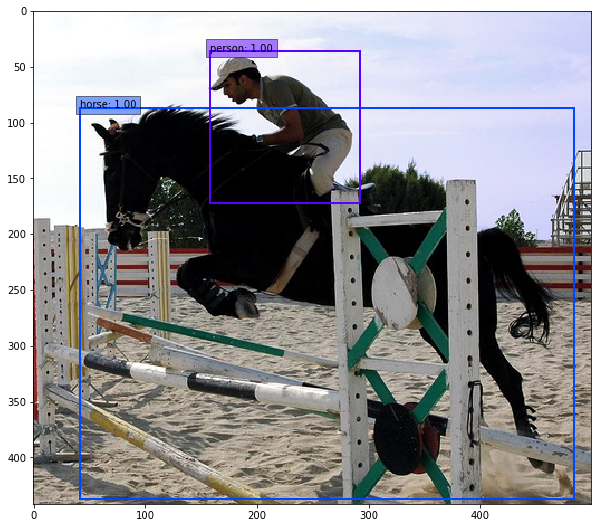

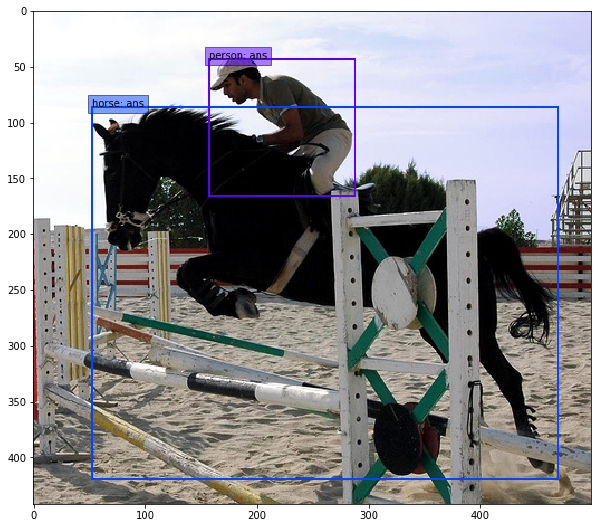

In [8]:
# 結果の描画
ssd = SSDPredictShow(img_list=train_img_list, dataset=train_dataset, eval_categories=voc_classes,
                     net=net, dataconfidence_level=0.6)
img_index = 0
ssd.show(img_index, "predict")
ssd.show(img_index, "ans")


/opt/conda/conda-bld/pytorch_1579022034529/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022034529/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


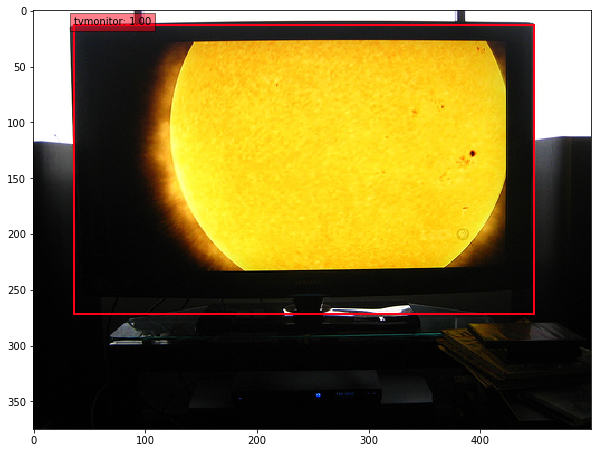

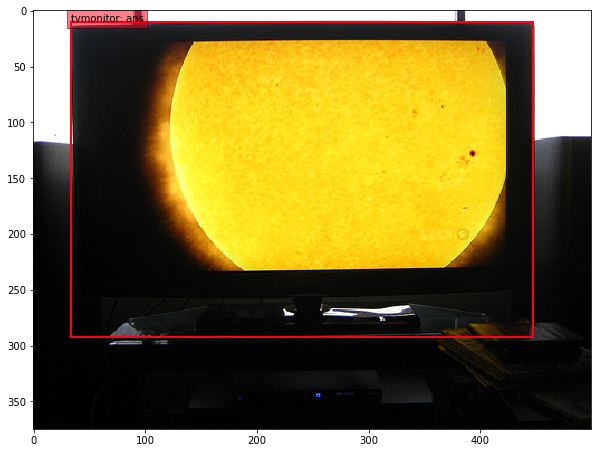

In [9]:
# 結果の描画
ssd = SSDPredictShow(img_list=val_img_list, dataset=val_dataset, eval_categories=voc_classes,
                     net=net, dataconfidence_level=0.6)
img_index = 0
ssd.show(img_index, "predict")
ssd.show(img_index, "ans")


以上